<a href="https://colab.research.google.com/github/rtlab1417/IIC-MS5611/blob/main/Arduino_UNO_IIC_on_altimeter_sensors_MS5611.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Studying IIC communication on altimeter sensors, MS5611 using Arduino UNO

The aim is to practice IIC communication protocol based on the datasheet using standard Arduino UNO library <Wire.h>.

## References:
1. https://github.com/RobTillaart/MS5611/blob/master/MS5611.cpp 
2. https://github.com/RobTillaart/MS5611/blob/master/MS5611.h
3. datasheet of MS5611-01BA03 Barometric Pressure Sensor, with stainless steel cap 

IIC communication sequences and data are compared to the references. RobTillaart.


---



## Materials
1. Arduino UNO x 1
2. MS5611 breakout  x 1
3. break board x 1
4. USB Logic Analyzer 24M 8CH Microcontroller
5. Jumper wires  

## Wiring
http://johnny-five.io/examples/barometer-MS5611/

UNO  <--> MS5611 breakout
* 5VDC --> Vcc
* GND  --> GND
* A4  --> SDA
* A5  --> SCL





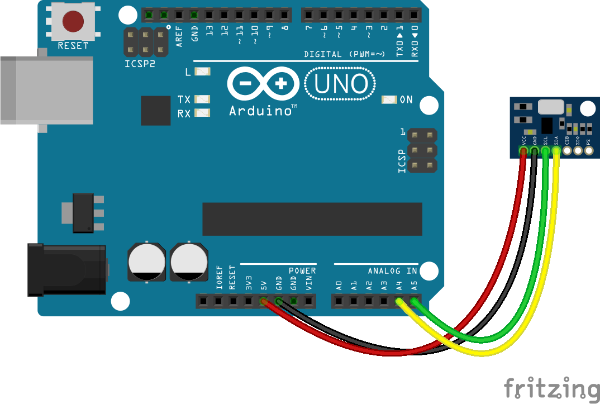

## Connection 

*Note: Only MS5611 is in the scope of studying.*

To study serial patterns of IIC, the connection of USB Logic Analyzer 24M 8CH Microcontroller is assigned as :

CH 0 - SDA

CH 1 - SCL

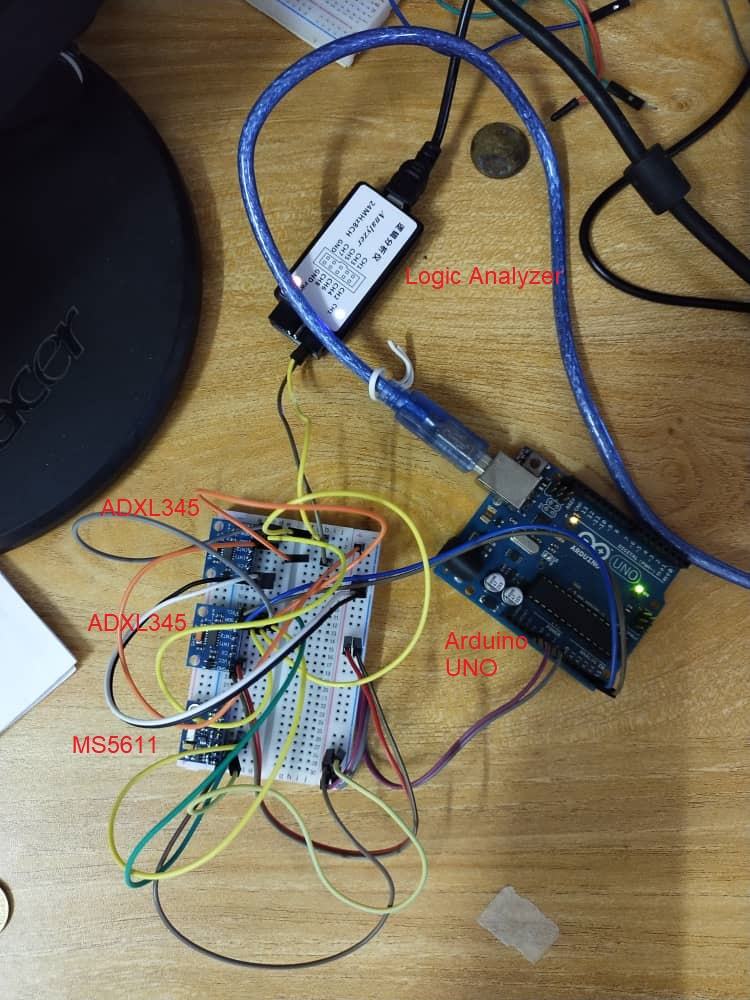

## Brief explanation on MS5611 breakout pins

https://protosupplies.com/product/gy-63-ms5611-pressure-temperature-sensor-module/

By default, CSB pin is grounded, MS5611 address is 0x77.

If CSB is connected to Vcc, MS5611 address is 0x77.

Default address is applied through-out this study.



---


---



## Steps of communication IIC

The MS5611-01BA has only five basic commands:
1. Reset
2. Read PROM (128 bit of calibration words)
3. D1 conversion
4. D2 conversion
5. Read ADC result (24 bit pressure / temperature) 

The program is built-up following the step 1 - step 5 as suggested by the datasheet.


---



### Importance addresses



```
// datasheet page 10
#define MS5611_CMD_READ_ADC       0x00
#define MS5611_CMD_READ_PROM      0xA0
#define MS5611_CMD_RESET          0x1E
#define MS5611_CMD_CONVERT_D1     0x40
#define MS5611_CMD_CONVERT_D2     0x50
#define MS5611_address            0x77
```



### Step 1: Reset

Once during powered ON or pressing reset on Arduino UNO.

MS5611 address is set at 0x77.

Standard <Wire.h> command to write reset at 0x1E.



```
// 1. Reset
void ms5611_reset()
{
  Wire.beginTransmission(MS5611_address);
  Wire.write(MS5611_CMD_RESET);
 
  _result = Wire.endTransmission();  // _result is not used in program.

}
```




### Step 2: Read from PROM

************ Part 1  **********************************

I reserved public unsigned 16-bit array for this purpose:


```
uint16_t  C[8]; // C[0] and C[7] not used
```

Read PROM (128 bit of calibration words)

read from 8 register (16 bits) - two bytes per read. then concatenate.

Ex: 0xA1 = upper byte, 0xA0 = lower byte

The PROM address: 0xA0,0xA2,0xA4,0xA6,0xA8,0xAA,0xA8,0xAC

then merge 2 bytes into C[i] of 16-bit length

example: C[1] = uppper_byte + lower_byte

************ Part 2  **********************************

Preparing calibration data with the magic number.

Pay attention to the data type at the beginning of program. Very critical.



```
// public variables
// calibration data
uint32_t C1;    // must be unsigned
uint32_t C2;    // must be unsigned
float C3;
float C4;
uint32_t C5;    // must be unsigned
float C6;
uint32_t dT;    // difference between actual and reference temperature
```





---



The codes for step 2: Reading from PROM and preparaing calibration data

In [ ]:
void ms5611_readProm()
{
// ******************************************************************* Part 1  ***************************************
for (uint8_t reg = 0; reg < 8; reg++)
  {
    uint8_t offset = reg * 2;
    Wire.beginTransmission(MS5611_address);
    Wire.write(MS5611_CMD_READ_PROM + offset); // starting from 0xA0, then offset of 2 ==> 0xA2...
    Wire.endTransmission();
  
    Wire.beginTransmission(MS5611_address);
    Wire.requestFrom(MS5611_address, 2);      // read 2 bytes from PROM. First read = upper_byte, second read = lower_byte

    int i = 0;
    while(Wire.available())
    {
     
      if (i == 0){  // first read  // by default 0x100  ==> 0x0100 == 16-bits
          C[reg] = Wire.read()*0x0100; // shift to left 1 byte // upper byte
          }
      if (i == 1){  // second read
          C[reg] += Wire.read(); // shift to left 1 byte // upper byte
          }
      i++;
     }
     Serial.println(C[reg], HEX); // check the data
  }
  Wire.endTransmission();
 
// ******************************************************************* Part 2  ***************************************
// once calibration data C1-C6 are read. Multiply with the magic number (refer to datasheet).
// public variables
// Prepare calibration data for later calculation of temperature and pressure.
// arrange C1 - C6  from prom[16]
C1  = C[1]*32768L;         //L = 32-bits.  2^15 = 0x00008000
C2  = C[2]*65536L;         //L = 32-bits.  2^16 = 0x00010000
C3  = C[3]*3.90625E-3;     // 1/2^8
C4  = C[4]*7.8125E-3;      // 1/2^7

// C5 = C[5] * 2^8 
// 32-bits. 256L = 0x0000 0100
// if only 256 = 0x0100 by default. which result C[5] upper byte being trimmed after multiplied.
C5  = C[5]*256L;
C6  = C[6]*1.1920928955E-7;  // C6 = C[6] / 2^23

 }

### Step 3: D1 Conversion

Digital Pressure value.

At the beginning of program, I have assigned public array of size-3, to store byte x 3 read.

```
byte ADC_D1[3];
```

Write to 0x40 (OSH 256), then read from from address 0x00.
24-bits reading. ==> read 3 times.

I save the data in array:
 

```
ADC_D1[i] = Wire.read()
```



---





The codes:

In [ ]:
// 3. D1 conversion
// Digital Pressure value
void ms5611_D1()
{
  Wire.beginTransmission(MS5611_address);
  Wire.write(MS5611_CMD_CONVERT_D1); // starting from 0x40
  Wire.endTransmission();

  delay(1);

  // read ADC
  Wire.beginTransmission(MS5611_address);
  Wire.write(MS5611_CMD_READ_ADC); // starting from 0x00
  Wire.endTransmission();
  
  Wire.beginTransmission(MS5611_address);
  Wire.requestFrom(MS5611_address, 3);

  int i = 0;
  while(Wire.available())
  {
    ADC_D1[i] = Wire.read();
    /*
    Serial.print("ADC_D1 ");
    Serial.print("[");
    Serial.print(i);
    Serial.print("]");
    Serial.print(" = ");
    Serial.println(ADC_D1[i], HEX);
    */
    i++;
    }
}

### Step 4. D2 conversion
Digital temperature value

At the beginning of program, I have assigned public array of size-3, to store byte x 3 read.

```
byte ADC_D2[3];
```

Write to 0x50 (OSH 256), then read from from address 0x00.
24-bits reading. ==> read 3 times.

I save the data in array:
 

```
ADC_D2[i] = Wire.read()
```



---




In [ ]:
// 4. D2 conversion
// Digital temperature value
void ms5611_D2()
{
  Wire.beginTransmission(MS5611_address);
  Wire.write(MS5611_CMD_CONVERT_D2); // starting from 0x50
  Wire.endTransmission();

  delay(1);

  // read ADC
  Wire.beginTransmission(MS5611_address);
  Wire.write(MS5611_CMD_READ_ADC); // starting from 0x00
  Wire.endTransmission();
  
  Wire.beginTransmission(MS5611_address);
  Wire.requestFrom(MS5611_address, 3);

  int i = 0;
  while(Wire.available())
  {
    ADC_D2[i] = Wire.read();
    /*
    Serial.print("ADC_D2 ");
    Serial.print("[");
    Serial.print(i);
    Serial.print("]");
    Serial.print(" = ");
    Serial.println(ADC_D2[i], HEX);
    */
    i++;
    }
}

## Logic Analyzer 

Use the logic analyzer to justify the signal patterns.

Setting: 7-bit, address only  ==> would show the same addresses as program.

### Step 1: Reset

Assume Arduino UNO' program is uploaded.

Press "Reset" button of Arduino UNO, click "Start" of logic analyzer.
Once reading, release "Reset" button.
The logic analyzer would read the very beginning of the IIC communication.
Note: Step 1 -> Reset, runs once at the starting og power On or Reset release.

Patterns:
* write to MS5611 address (0x77),
* write to  reset address (0x1E)


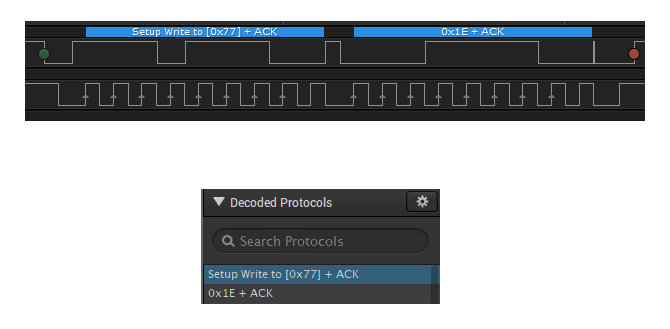

### Step 2: Read from PROM
patterns 
* write to MS5611 address (0x77),
* write to PROM address (0xA0)
* Read from PROM x 2 byte (upper byte then lower byte)

Repeat the same till 0xAE (PROM address).




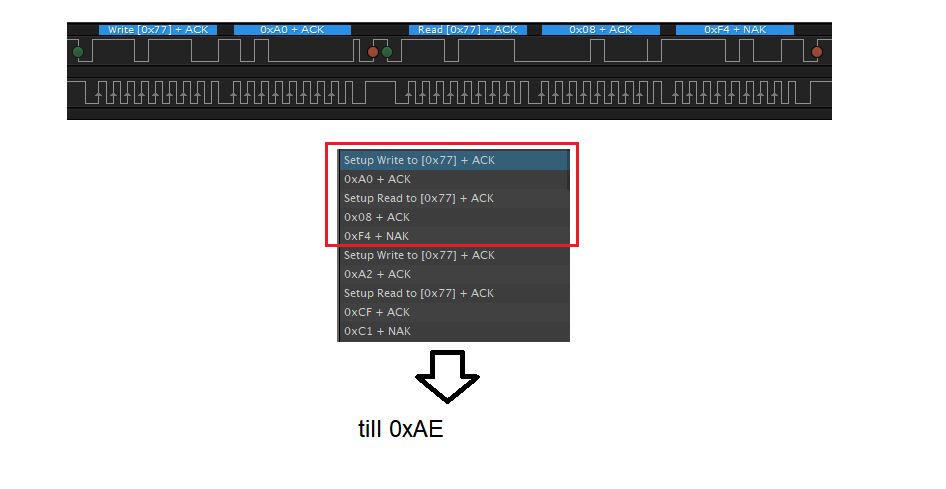

### Step 3: D1 Conversion


patterns 
* write to MS5611 address (0x77),
* write to D1 address (0x40) ==> OSH256
* Read from ADC Read (0x00) x 3 bytes (upper byte, middle byte then lowest byte)



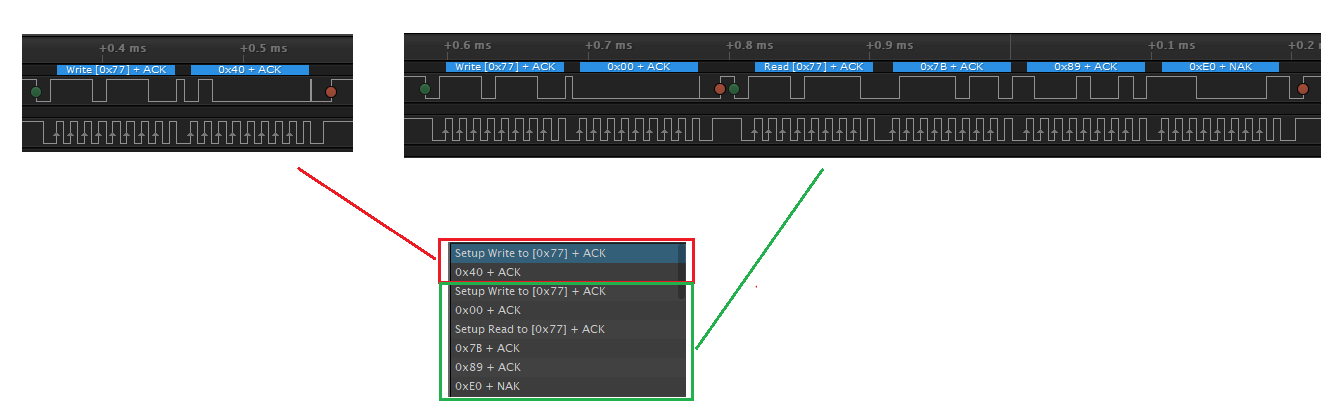

### Step 4: D2 Conversion


patterns 
* write to MS5611 address (0x77),
* write to D2 address (0x50) ==> OSH256
* Read from ADC Read (0x00) x 3 bytes (upper byte, middle byte then lowest byte)


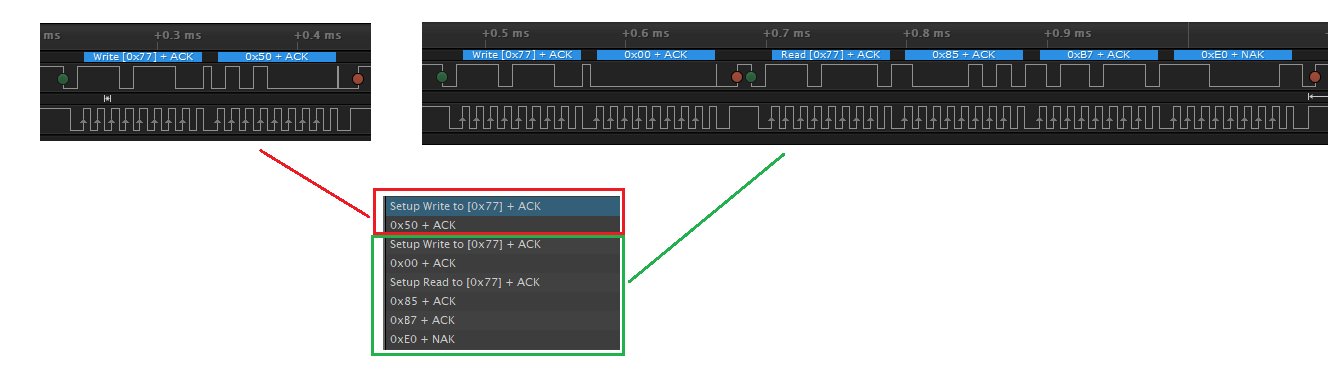

## The Math

Formulaes provided by the datasheet

1.   Calculate temperature
2.   Calculate temperature compensated pressure

Referring to page 10 - the data sheet.


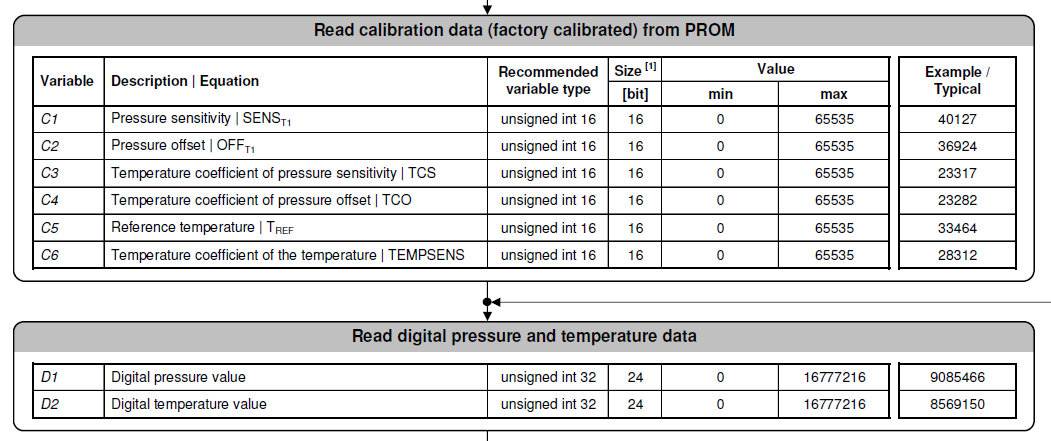

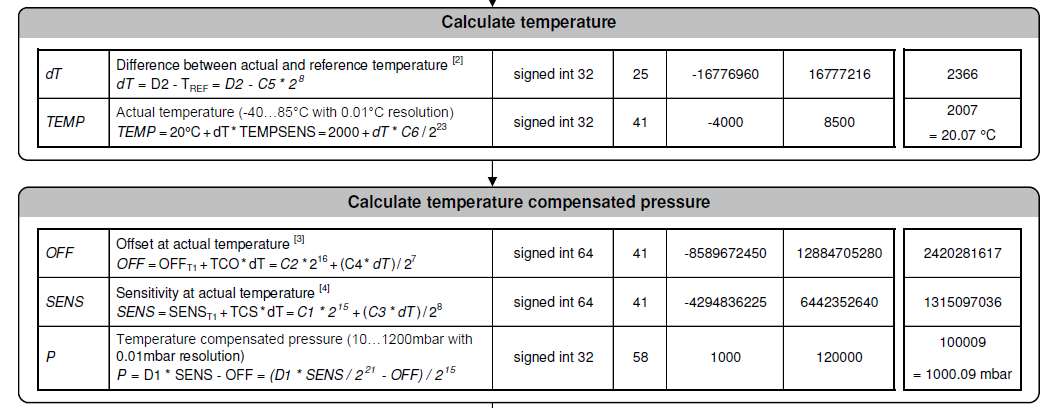

### Preparing magic number -> as formula

It is a good idea to pre-determine the "magic" number as suggested in RobTillaart.

Refer to page 10 of the data sheet. Multiply with the calibration data.

Refer to the program. Note the data type. Very important.

C1 => $2^{15}=32768$

C2 => $2^{16}=65536$

C3 => $\frac{1}{2^{8}}=3.90625E-03$ 

C4 => $\frac{1}{2^{7}}=7.8125E-3$ 

C5 => $2^{8}=256$

C6 => $\frac{1}{2^{23}}=1.1920928955E-7$ 


$\frac{1}{2^{21}}=4.76837158E-7$ 

$\frac{1}{2^{15}}=3.051757813E-5$



---




### Step 1: Calculate temperature

1. merge D2 data => upper + middle + lower => unsigned int 32



```
  // or using this method: using bit left-shift and merge
  uint32_t D2_val = (((uint32_t)ADC_D2[0]) << 16) | (((uint32_t)ADC_D2[1]) << 8) | ADC_D2[2];
```
Shift upper byte 16-bits left, shift middle byte 8-bits left. Concatenate all 3 bytes into unsigned int 32

Apply the formula for temperature. Use the magic numbers.



```
  dT = D2_val - C5;       //dT = D2 - C5*2^8
  uint32_t Temp = 2000 + dT*C6;    //Temp = 2000 + dT * C6/2^23
```



---
The code as below for calculate temperature.






In [ ]:
// 5. Calculate temperature
// refer to the datasheet. The formula

uint32_t calTemperature()
{
  // signed int 32
  // formula
  // dT = D2 - C5*2^8
  // Temp = 2000 + dT * C6/2^23

  // merge 3 bytes of D2 ADC_read
  // this method 1: using multiplier
  //uint32_t D2_val = ADC_D2[0] * 65536UL; // upper byte // 65536UL; // shift left 3 bytes
  //D2_val += ADC_D2[1] * 256UL; //256UL; //second byte // shift left 2 bytes
  //D2_val += ADC_D2[2];

  // or using this method: using bit left-shift and merge
  uint32_t D2_val = (((uint32_t)ADC_D2[0]) << 16) | (((uint32_t)ADC_D2[1]) << 8) | ADC_D2[2];
 
  // applying the formula
  dT = D2_val - C5;       //dT = D2 - C5*2^8
  uint32_t Temp = 2000 + dT*C6;    //Temp = 2000 + dT * C6/2^23

  return Temp;
}

### Step 2: Calculate temperature compensated pressure

1. merge D1 data => upper + middle + lower => unsigned int 32

```
uint32_t D1_val = (((uint32_t)ADC_D1[0]) << 16) | (((uint32_t)ADC_D1[1]) << 8) | ADC_D1[2];
```
pre-arrange the magic numbers to simplify the maths. 

Note: pay attention to the data type.  Type float is used instead of ingned int 64 and signed int 32.

*Note: Serial.print() cannot handle int64. *



---




The codes for calculating temperature compensated pressure

In [ ]:
float calPressure()
{
  // applying public variables, C1-> C6
  // offset at actual temperature, OFF = C2+ C4*dT
  float OFF = C2 + C4*dT;
  float SENS = C1 + C3*dT;
  
  // Temperature compensated pressure, P = (D1*SENS*k1-OFF)*k2
  float k1  = 4.76837158E-7;  // 1/2^21
  float k2  = 3.051757813E-5;  // 1/2^15
 
  // or using this method: using bit left-shift and merge
  uint32_t D1_val = (((uint32_t)ADC_D1[0]) << 16) | (((uint32_t)ADC_D1[1]) << 8) | ADC_D1[2];

  // P = (D1_val*SENS*k1-OFF)k2
  float P = D1_val*SENS*k1-OFF;
  P *=k2;
  
  return P;
  
}


## Results of Temperature and Pressure

Eventually the results of temperature (°C) and pressure  (mBar).

The main loop:



```
void loop()
{
  ms5611_D1();   // read D1 ADC
  ms5611_D2();   // read D2 ADC
  Serial.print("Temperature = ");
  Serial.print(calTemperature()*0.01, 2);
  Serial.print("°");
  Serial.print("C");
  Serial.print("\t\t");
  Serial.print("Pressure = ");
  Serial.print(calPressure()*0.01,2);
  Serial.println(" mBar");
  delay(500);
}
```





## Completed Code

I leave the comments. Hopefully would help the understanding. 

1. Read/Write IIC from/to Arduino UNO <-> MS5611.

2. Pre-treatment of byte data - concatenate into PROM 16-bit data and ADCRead 24-bit data.

3. Preparing "magic" numbers - according to the formulas. For ease of math in Arduino UNO.

4. Applying formula as recommended by the datasheet - temperature and pressure.



---



In [ ]:
/*
 * The aim is to write IIC to read from MS5611 using standard arduino library
 * <Wire.h>
 * 
 * Training to write IIC according to its datasheet
 * Referring to MS5611-01BA03 datasheet

  The MS5611-01BA has only five basic commands:
  1. Reset
  2. Read PROM (128 bit of calibration words)
  3. D1 conversion
  4. D2 conversion
  5. Calculate temperature 
  6. Calculate temperature compensated pressure
 * 
 * references: Rob Tillaart. VERSION: 0.2.1
 * 1. https://github.com/RobTillaart/MS5611/blob/master/MS5611.cpp
 * 2. https://github.com/RobTillaart/MS5611/blob/master/MS5611.h
 *
 */


#include<Wire.h>

// datasheet page 10
#define MS5611_CMD_READ_ADC       0x00
#define MS5611_CMD_READ_PROM      0xA0
#define MS5611_CMD_RESET          0x1E
#define MS5611_CMD_CONVERT_D1     0x40
#define MS5611_CMD_CONVERT_D2     0x50
#define MS5611_address            0x77

// public variables
int _result = -999;

//byte prom[16];    // merge prom reading and C in a function. 
uint16_t  C[8]; // C[0] and C[7] not used
byte ADC_D1[3];
byte ADC_D2[3];
char output[512];
char output2[512];

// public variables
// calibration data
uint32_t C1;    // must be unsigned
uint32_t C2;    // must be unsigned
float C3;
float C4;
uint32_t C5;    // must be unsigned
float C6;
uint32_t dT;    // difference between actual and reference temperature

// 1. Reset
void ms5611_reset()
{
  Wire.beginTransmission(MS5611_address);
  Wire.write(MS5611_CMD_RESET);
 
  _result = Wire.endTransmission();

}


// 2. Read PROM (128 bit of calibration words)
// read from 8 register (16 bits) - two bytes per read. then concatenate.
// Ex: 0xA1 = upper byte, 0xA0 = lower byte
// address 0 - 7
// 0xA0,0xA2,0xA4,0xA6,0xA8,0xAA,0xA8,0xAC
// then merge 2 bytes into C[i] of 16-bit length
// example: C[1] = uppper_byte + lower_byte

void ms5611_readProm()
{

for (uint8_t reg = 0; reg < 8; reg++)
  {
    uint8_t offset = reg * 2;
    Wire.beginTransmission(MS5611_address);
    Wire.write(MS5611_CMD_READ_PROM + offset); // starting from 0xA0, then offset of 2 ==> 0xA2...
    Wire.endTransmission();
  
    Wire.beginTransmission(MS5611_address);
    Wire.requestFrom(MS5611_address, 2);      // read 2 bytes from PROM. First read = upper_byte, second read = lower_byte

    int i = 0;
    while(Wire.available())
    {
     
      if (i == 0){  // first read  // by default 0x100  ==> 0x0100 == 16-bits
          C[reg] = Wire.read()*0x0100; // shift to left 1 byte // upper byte
          }
      if (i == 1){  // second read
          C[reg] += Wire.read(); // shift to left 1 byte // upper byte
          }
      i++;
     }
     Serial.println(C[reg], HEX); // check the data
  }
  Wire.endTransmission();

// once calibration data C1-C6 are read. Multiply with the magic number (refer to datasheet).
// public variables
// Prepare calibration data for later calculation of temperature and pressure.
// arrange C1 - C6  from prom[16]
C1  = C[1]*32768L;         //L = 32-bits.  2^15 = 0x00008000
C2  = C[2]*65536L;         //L = 32-bits.  2^16 = 0x00010000
C3  = C[3]*3.90625E-3;     // 1/2^8
C4  = C[4]*7.8125E-3;      // 1/2^7

// C5 = C[5] * 2^8 
// 32-bits. 256L = 0x0000 0100
// if only 256 = 0x0100 by default. which result C[5] upper byte being trimmed after multiplied.
C5  = C[5]*256L;
C6  = C[6]*1.1920928955E-7;  // C6 = C[6] / 2^23

 }

// 3. D1 conversion
// Digital Pressure value
void ms5611_D1()
{
  Wire.beginTransmission(MS5611_address);
  Wire.write(MS5611_CMD_CONVERT_D1); // starting from 0x40
  Wire.endTransmission();

  delay(1);

  // read ADC
  Wire.beginTransmission(MS5611_address);
  Wire.write(MS5611_CMD_READ_ADC); // starting from 0x00
  Wire.endTransmission();
  
  Wire.beginTransmission(MS5611_address);
  Wire.requestFrom(MS5611_address, 3);

  int i = 0;
  while(Wire.available())
  {
    ADC_D1[i] = Wire.read();
    /*
    Serial.print("ADC_D1 ");
    Serial.print("[");
    Serial.print(i);
    Serial.print("]");
    Serial.print(" = ");
    Serial.println(ADC_D1[i], HEX);
    */
    i++;
    }
}

// 4. D2 conversion
// Digital temperature value
void ms5611_D2()
{
  Wire.beginTransmission(MS5611_address);
  Wire.write(MS5611_CMD_CONVERT_D2); // starting from 0x50
  Wire.endTransmission();

  delay(1);

  // read ADC
  Wire.beginTransmission(MS5611_address);
  Wire.write(MS5611_CMD_READ_ADC); // starting from 0x00
  Wire.endTransmission();
  
  Wire.beginTransmission(MS5611_address);
  Wire.requestFrom(MS5611_address, 3);

  int i = 0;
  while(Wire.available())
  {
    ADC_D2[i] = Wire.read();
    /*
    Serial.print("ADC_D2 ");
    Serial.print("[");
    Serial.print(i);
    Serial.print("]");
    Serial.print(" = ");
    Serial.println(ADC_D2[i], HEX);
    */
    i++;
    }
}

// 5. Calculate temperature
// refer to the datasheet. The formula

uint32_t calTemperature()
{
  // signed int 32
  // formula
  // dT = D2 - C5*2^8
  // Temp = 2000 + dT * C6/2^23

  // merge 3 bytes of D2 ADC_read
  // this method 1: using multiplier
  //uint32_t D2_val = ADC_D2[0] * 65536UL; // upper byte // 65536UL; // shift left 3 bytes
  //D2_val += ADC_D2[1] * 256UL; //256UL; //second byte // shift left 2 bytes
  //D2_val += ADC_D2[2];

  // or using this method: using bit left-shift and merge
  uint32_t D2_val = (((uint32_t)ADC_D2[0]) << 16) | (((uint32_t)ADC_D2[1]) << 8) | ADC_D2[2];
 
 /*
  Serial.print("D2 value = ");
  Serial.print(D2_val);
  Serial.print("    ");
  Serial.println(D2_val, HEX);

  Serial.print("C1 =  ");
  Serial.print(C1, HEX);
  Serial.print("    ");
  Serial.println(C1);

  Serial.print("C2 =  ");
  Serial.print(C2, HEX);
  Serial.print("    ");
  Serial.println(C2);

  Serial.print("C3 =  ");
  Serial.print(C3, HEX);
  Serial.print("    ");
  Serial.println(C3, 10);
  
  Serial.print("C4 =  ");
  Serial.print(C4, HEX);
  Serial.print("    ");
  Serial.println(C4, 10);

  Serial.print("C5 =  ");
  Serial.print(C5, HEX);
  Serial.print("    ");
  Serial.println(C5);

  Serial.print("C6 =  ");
  Serial.print(C6, HEX);
  Serial.print("    ");
  Serial.println(C6, 10);
*/

 // applying the formula
  dT = D2_val - C5;       //dT = D2 - C5*2^8
  uint32_t Temp = 2000 + dT*C6;    //Temp = 2000 + dT * C6/2^23
  //Serial.print("dT=  ");
  //Serial.println(dT);
  
  //Serial.print("dT =  ");
  //Serial.println(dT);
  //Serial.print("Temp=  ");
  //Serial.println(Temp);

  return Temp;
}


// 6. Calculate temperature compensated pressure
// signed int 64
// use calibration data C1-C5
// offset at actual temperature, OFF = C2*2^16 + (C4*dT)/2^7
// Sensitivity at actual temperature. SENS = C1*2^15 + (C3*dT)/2^8
// Temperature compensated pressure, P = (D1*SENS/2^21-OFF)/2^15

float calPressure()
{
  // applying public variables, C1-> C6
  // offset at actual temperature, OFF = C2+ C4*dT
  float OFF = C2 + C4*dT;
  //Serial.print("offset = ");
  //Serial.println(OFF);
  // Sensitivity at actual temperature. SENS = C1*2^15 + (C3*dT)/2^8
  float SENS = C1 + C3*dT;
  //Serial.print("SENS = ");
  //Serial.println(SENS);
  
  // Temperature compensated pressure, P = (D1*SENS*k1-OFF)*k2
  float k1  = 4.76837158E-7;  // 1/2^21
  float k2  = 3.051757813E-5;  // 1/2^15
  // or using this method: using bit left-shift and merge
  uint32_t D1_val = (((uint32_t)ADC_D1[0]) << 16) | (((uint32_t)ADC_D1[1]) << 8) | ADC_D1[2];
  //Serial.print("D1 value = ");
  //Serial.print(D1_val);
  //Serial.print("    ");
  //Serial.println(D1_val, HEX);
  // P = (D1_val*SENS*k1-OFF)k2
  float P = D1_val*SENS*k1-OFF;
  P *=k2;
  
  return P;
  
  //Serial.print("pressure = ");
  //Serial.println(P);
}


void setup()
{
  Wire.begin();
  Serial.begin(9600);
  //Serial.print(" before reset, result = ");
  //Serial.println(_result);

    // Step 1: reset
  ms5611_reset(); // ** address 0x77
  //Serial.print(" after reset, result = ");
  //Serial.println(_result);
  delay(5);

  ms5611_readProm();

}

void loop()
{
  ms5611_D1();
  ms5611_D2();
  Serial.print("Temperature = ");
  Serial.print(calTemperature()*0.01, 2);
  Serial.print("°");
  Serial.print("C");
  Serial.print("\t\t");
  Serial.print("Pressure = ");
  Serial.print(calPressure()*0.01,2);
  Serial.println(" mBar");
  delay(500);
}

## What is not included in this study

1. altitude calculation according to the atmosphere pressure. Looking for suitable equation

2. SECOND ORDER TEMPERATURE COMPENSATION  as recommended by the datasheet. Could use RobTillaart's library directly